<a href="https://colab.research.google.com/github/yodavo/moja-global-analysis/blob/main/2021-12-16_Task2-Holdrigde/lifezones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# load requirements
%cd /home/davo/Code/moja-global-analysis/2021-12-16_Task2-Holdrigde

/home/davo/Code/moja-global-analysis/2021-12-16_Task2-Holdrigde


In [7]:
import os, zipfile, glob
import rasterio
from osgeo import gdal
import geopandas as gpd
import pandas as pd
import rasterstats
import numpy as np
from rasterio.plot import show
from rasterio.plot import show_hist
from matplotlib import pyplot as plt
from shapely.geometry import Point
from matplotlib import pyplot
import georasters as gr

In [3]:
# creating folder to store information
# %mkdir clip_shapefiles
# %mkdir outcomes
# %mkdir lifezones

# **Clipping**

In [23]:
# Function to clip rasters
def clip_raster(list_raster, inshp, wordclim_dataset):
  ''' Get a clipped raster from the Worldclim data for specified countries:
  - list_raster : geotiff fetched from Worldclim
  - inshp : path clipped shapefile with the name of the country
  - wordclim_dataset: name of the dataset for outraster file name '''
  for i in list_raster:
    name, raster = i
    outraster = './outcomes/' + str(wordclim_dataset) + '_' + str.upper(name) + '.tif'
    dsClip = gdal.Warp(outraster, raster, cutlineDSName=inshp, cropToCutline=True, dstNodata=-999)
    
    # visualization
    # plt.imshow(dsClip.GetRasterBand(1).ReadAsArray())
    # plt.colorbar()
    # plt.title(str.capitalize(wordclim_dataset) + ' - ' + str.upper(name))

# **Boundaries**

In [19]:
# importing the data
world_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# subseting
world_df = world_df[['continent','name', 'iso_a3','geometry']]

# croppping boundaries
colombia_bd = world_df.loc[world_df.name == 'Colombia', ].reset_index(drop=True)
colombia_bd.to_file("./clip_shapefiles/colombia.shp")
belize_bd = world_df.loc[world_df.name == 'Belize', ].reset_index(drop=True)
belize_bd.to_file("./clip_shapefiles/belize.shp")

# path to shapefiles
colombia = './clip_shapefiles/colombia.shp'
belize = './clip_shapefiles/belize.shp'

# **Fetching Elevation 2.5m**

In [24]:
# fetching elevation geotif form worldclim 2.5m
! wget https://biogeo.ucdavis.edu/data/worldclim/v2.1/base/wc2.1_2.5m_elev.zip -q --show-progress
with zipfile.ZipFile('wc2.1_2.5m_elev.zip', 'r') as tempm:
  tempm.extractall("temp")

# path to the folder
files = glob.glob(os.path.join('./temp', '*tif'))

####################### tiff file #################################
# Rename and arrange the information
name = files[0][files[0].rfind('/')+1 : files[0].rfind('.')]

# merging all the metadata
tiff_dem2_5 = [(name, gdal.Open(files[0]))]

############################ Clippping maps #################################
# Colombia
clip_raster(tiff_dem2_5, colombia, 'Colombia')

# Belize
clip_raster(tiff_dem2_5, belize, 'Belize')

##################### Removing Cache ################################
%rm "wc2.1_2.5m_elev.zip"
%rm -r "temp"

wc2.1_2.5m_elev.zip 100%[===================>]  16.75M  5.94MB/s    in 2.8s    


# **Fetching Elevation 30s**

In [25]:
# fetching elevation geotif form worldclim 30s
! wget https://biogeo.ucdavis.edu/data/worldclim/v2.1/base/wc2.1_30s_elev.zip -q --show-progress
with zipfile.ZipFile('wc2.1_30s_elev.zip', 'r') as tempm:
  tempm.extractall("temp")

# path to the folder
files = glob.glob(os.path.join('./temp', '*tif'))

####################### tiff file #################################
# Rename and arrange the information
name = files[0][files[0].rfind('/')+1 : files[0].rfind('.')]

# merging all the metadata
tiff_dem30 = [(name, gdal.Open(files[0]))]

############################ Clippping maps #################################
# Colombia
clip_raster(tiff_dem30, colombia, 'Colombia')

# Belize
clip_raster(tiff_dem30, belize, 'Belize')

##################### Removing Cache ################################
%rm "wc2.1_30s_elev.zip"
%rm -r "temp"

wc2.1_30s_elev.zip  100%[===================>] 322.52M  2.12MB/s    in 1m 57s  


# **Elevation list** `elev_colombia` - `elev_belize`

In [26]:
############### Elevation information ################################
# path to the folder
eleva = glob.glob(os.path.join('./outcomes', '*tif'))

###### list of tiff files ######
# Rename and arrange the information
eleva_names = [i[i.rfind('/')+1:-4] for i in eleva]
eleva_names.sort()

##################### elevations #########################################
# Separate datasets (this is pretty redundant)
elev_Belize, elev_Colombia = [i for i in eleva_names if i.startswith('Belize')], [i for i in eleva_names if i.startswith('Colombia')]

# reading the data
pathe, exte = './outcomes/', '.tif'

# importing and handling
elev_belize = []
for i in elev_Belize:
  name = i
  ds = rasterio.open(pathe + i + exte, 'r')
  data = ds.read()
  max = np.nanmax(data)
  min = np.nanmin(data)
  elev_belize.append((name, ds, data, min, max))

elev_colombia = []
for i in elev_Colombia:
  name = i
  ds = rasterio.open(pathe + i + exte, 'r')
  data = ds.read()
  max = np.nanmax(data)
  min = np.nanmin(data)
  elev_colombia.append((name, ds, data, min, max))

# **Temperature** `amt_colombia` - `amt_belize`  **and Precipitation list** `tpa_colombia` - `tap_belize` 

- **AMT** - BIO2 = Mean Diurnal Range (Mean of monthly (max temp - min temp))
- **TPA** - BIO12 = Annual Precipitation



In [28]:
#########################################################################
#################### Manual retrival ####################################
#########################################################################

# get the information in the zip file
with zipfile.ZipFile('clip_tiffWorldclim[Colombia-Belize].zip', 'r') as temp:
  temp.extractall("rasters")

# path to the folder
files = glob.glob(os.path.join('./rasters', '*tif'))

###### list of tiff files ######
# Rename and arrange the information
names = [i[i.rfind('/')+1:-4] for i in files]

# Separate datasets (this is pretty redundant)
belize, colombia = [i for i in names if i.startswith('Belize')], [i for i in names if i.startswith('Colombia')]

# It will work only on 2.5s and 30s maps(Columbia 15, Belize 13)
Belize, Colombia = [i for i in belize if i[14:16] in ['30', '2_']], [i for i in colombia if i[16:18] in ['30', '2_']]

FileNotFoundError: [Errno 2] No such file or directory: 'clip_tiffWorldclim[Colombia-Belize].zip'

In [11]:
##################### Rasters temperature ######################################
# reading the data
path, ext = '/content/rasters/', '.tif'

# importing and handling
amt_belize = []
for i in Belize:
  if i.endswith('BIO2'):
    name = i
    ds = rasterio.open(path + i + ext, 'r')
    data = ds.read()
    max = np.nanmax(data)
    min = np.nanmin(data)
    amt_belize.append((name, ds, data, min, max))
  else:
    next

amt_colombia = []
for i in Colombia:
  if i.endswith('BIO2'):
    name = i
    ds = rasterio.open(path + i + ext, 'r')
    data = ds.read()
    max = np.nanmax(data)
    min = np.nanmin(data)
    amt_colombia.append((name, ds, data, min, max))
  else:
    next

amt_belize.sort()
amt_colombia.sort()

In [12]:
##################### Rasters temperature ######################################
# reading the data
path, ext = '/content/rasters/', '.tif'

# importing and handling
tpa_belize = []
for i in Belize:
  if i.endswith('BIO12'):
    name = i
    ds = rasterio.open(path + i + ext, 'r')
    data = ds.read()
    max = np.nanmax(data)
    min = np.nanmin(data)
    tpa_belize.append((name, ds, data, min, max))
  else:
    next

tpa_colombia = []
for i in Colombia:
  if i.endswith('BIO12'):
    name = i
    ds = rasterio.open(path + i + ext, 'r')
    data = ds.read()
    max = np.nanmax(data)
    min = np.nanmin(data)
    tpa_colombia.append((name, ds, data, min, max))
  else:
    next

tpa_belize.sort()
tpa_colombia.sort()

In [13]:
# removing zip folder
%rm "clip_tiffWorldclim[Colombia-Belize].zip"
%rm -r "rasters"

# **Life Zones Reported** - reclassify

In [120]:
# function to reclassify the arrays/rasters
def array_clean(array_change, lista):
  array = array_change.copy()
  for i in lista:
    p1, p2, value = i
    if (p1 == 0.0) & (np.isnan(p2)):
      array[np.where((array == 0))] = value
    elif np.isnan(p2):
      array[np.where((array >= p1))] = value
    else:
      array[np.where((array >= p1) & (array <= p2))] = value
  return array

## **Holdrige Colombia 2005**

| id    | simbolo | zona                            | leyenda              | amt1_c | amt2_c | temperature | pta1_mm | pta2_mm | precipitation | elev1_m | elev2_m | elevation |
|-------|---------|---------------------------------|----------------------|--------|--------|-------------|---------|---------|---------------|---------|---------|-----------|
| 2.3   | N       | Nieve                           | Nival                | 0      | 1.5    | 0.1         | 0       |         | 1             | 4500    |         | 23        |
| 8.8   | Ts-A    | Tundra seca alpina              | Páramo seco          | 1.5    | 3      | 0.2         | 62.5    | 125     | 2             | 3500    | 4500    | 22        |
| 13.2  | Th-A    | Tundra húmeda alpina            | Páramo húmedo        | 1.5    | 3      | 0.2         | 125     | 250     | 3             | 3500    | 4500    | 22        |
| 17.6  | Tmh-A   | Tundra muy húmeda alpina        | Páramo muy húmedo    | 1.5    | 3      | 0.2         | 250     | 500     | 4             | 3500    | 4500    | 22        |
| 22    | Tp-A    | Tundra pluvial                  | Páramo pluvial       | 1.5    | 3      | 0.2         | 500     |         | 5             | 3500    | 4500    | 22        |
| 12.6  | d-SA    | Desierto subalpino              | Subpáramo muy seco   | 3      | 6      | 0.3         | 62.5    | 125     | 2             | 3000    | 3500    | 21        |
| 18.9  | Md-SA   | Matorral desértico subalpino    | Subpáramo seco       | 3      | 6      | 0.3         | 125     | 250     | 3             | 3000    | 3500    | 21        |
| 25.2  | Mh-SA   | Monte húmedo subalpino          | Subpáramo húmedo     | 3      | 6      | 0.3         | 250     | 500     | 4             | 3000    | 3500    | 21        |
| 31.5  | p-SA    | Páramo subalpino                | Subpáramo muy húmedo | 3      | 6      | 0.3         | 500     | 1000    | 5             | 3000    | 3500    | 21        |
| 37.8  | Pp-SA   | Páramo pluvial subalpino        | Subpáramo pluvial    | 3      | 6      | 0.3         | 1000    |         | 6             | 3000    | 3500    | 21        |
| 16    | d-M     | Desierto montano                | Muy frío seco        | 6      | 12     | 0.4         | 62.5    | 125     | 2             | 2500    | 3000    | 20        |
| 24    | Md-M    | Matorral desértico montano      | Muy frío seco        | 6      | 12     | 0.4         | 125     | 250     | 3             | 2500    | 3000    | 20        |
| 32    | e-M     | Estepa montana                  | Muy frío seco        | 6      | 12     | 0.4         | 250     | 500     | 4             | 2500    | 3000    | 20        |
| 40    | Bh-M    | Bosque húmedo montano           | Muy frío húmedo      | 6      | 12     | 0.4         | 500     | 1000    | 5             | 2500    | 3000    | 20        |
| 48    | Bmh-M   | Bosque muy húmedo montano       | Muy frío muy húmedo  | 6      | 12     | 0.4         | 1000    | 2000    | 6             | 2500    | 3000    | 20        |
| 56    | Bp-M    | Bosque pluvial montano          | Muy frío pluvial     | 6      | 12     | 0.4         | 2000    |         | 7             | 2500    | 3000    | 20        |
| 19    | d-MB    | Desierto montano bajo           | Frío muy seco        | 12     | 18     | 0.5         | 62.5    | 125     | 2             | 2000    | 2500    | 19        |
| 28.5  | Md-MB   | Matorral desértico montano bajo | Frío muy seco        | 12     | 18     | 0.5         | 125     | 250     | 3             | 2000    | 2500    | 19        |
| 38    | Ee-MB   | Estepa espinosa montano bajo    | Frío muy seco        | 12     | 18     | 0.5         | 250     | 500     | 4             | 2000    | 2500    | 19        |
| 47.5  | Bs-Mb   | Bosque seco montano bajo        | Frío seco            | 12     | 18     | 0.5         | 500     | 1000    | 5             | 2000    | 2500    | 19        |
| 57    | Bh-MB   | Bosque húmedo montano bajo      | Frío húmedo          | 12     | 18     | 0.5         | 1000    | 2000    | 6             | 2000    | 2500    | 19        |
| 66.5  | Bmh-MB  | Bosque muy húmedo montano bajo  | Frío muy húmedo      | 12     | 18     | 0.5         | 2000    | 4000    | 7             | 2000    | 2500    | 19        |
| 76    | Bp-MB   | Bosque pluvial montano bajo     | Frío pluvial         | 12     | 18     | 0.5         | 4000    |         | 8             | 2000    | 2500    | 19        |
| 21.6  | d-PM    | Desierto premontano             | Templado muy seco    | 18     | 24     | 0.6         | 62.5    | 125     | 2             | 1000    | 2000    | 18        |
| 32.4  | Md-PM   | Matorral desértico premontano   | Templado muy seco    | 18     | 24     | 0.6         | 125     | 250     | 3             | 1000    | 2000    | 18        |
| 43.2  | Me-PM   | Matorral espinoso premontano    | Templado muy seco    | 18     | 24     | 0.6         | 250     | 500     | 4             | 1000    | 2000    | 18        |
| 54    | Bs-PM   | Bosque seco premontano          | Templado seco        | 18     | 24     | 0.6         | 500     | 1000    | 5             | 1000    | 2000    | 18        |
| 64.8  | Bh-PM   | Bosque húmedo premontano        | Templado húmedo      | 18     | 24     | 0.6         | 1000    | 2000    | 6             | 1000    | 2000    | 18        |
| 75.6  | Bmh-PM  | Bosque muy húmedo premontano    | Templado muy húmedo  | 18     | 24     | 0.6         | 2000    | 4000    | 7             | 1000    | 2000    | 18        |
| 86.4  | Bp-PM   | Bosque pluvial premontano       | Templado pluvial     | 18     | 24     | 0.6         | 4000    |         | 8             | 1000    | 2000    | 18        |
| 23.8  | d-T     | Desierto Tropical               | Cálido árido         | 24     |        | 0.7         | 62.5    | 125     | 2             | 0       | 1000    | 17        |
| 35.7  | Md-ST   | Matorral desértico subtropical  | Cálido árido         | 24     |        | 0.7         | 125     | 250     | 3             | 0       | 1000    | 17        |
| 47.6  | Me-ST   | Monte espinoso subtropical      | Cálido semiárido     | 24     |        | 0.7         | 250     | 500     | 4             | 0       | 1000    | 17        |
| 59.5  | Bms-T   | Bosque muy seco tropical        | Cálido muy seco      | 24     |        | 0.7         | 500     | 1000    | 5             | 0       | 1000    | 17        |
| 71.4  | Bs-T    | Bosque seco tropical            | Cálido seco          | 24     |        | 0.7         | 1000    | 2000    | 6             | 0       | 1000    | 17        |
| 83.3  | Bh-T    | Bosque húmedo tropical          | Cálido húmedo        | 24     |        | 0.7         | 2000    | 4000    | 7             | 0       | 1000    | 17        |
| 95.2  | Bmh-T   | Bosque muy húmedo tropical      | Cálido muy húmedo    | 24     |        | 0.7         | 4000    | 8000    | 8             | 0       | 1000    | 17        |
| 107.1 | Bp-T    | Bosque pluvial tropical         | Cálido pluvial       | 24     |        | 0.7         | 8000    |         | 9             | 0       | 1000    | 17        |

In [155]:
# Working with Holdrigde 2005
hold = pd.read_csv('https://raw.githubusercontent.com/yodavo/moja-global-analysis/main/2021-12-16_Task2-Holdrigde/dataset/holdrigde_Colombia(2005).csv',
                   na_values = '')

# creating dataframes to compare
precipitation = hold[['pta1_mm', 'pta2_mm', 'precipitation']].copy().sort_values(by='pta2_mm').drop_duplicates(subset='precipitation').sort_values(by='pta1_mm').reset_index(drop=True).values.tolist()
temperature = hold[['amt1_c', 'amt2_c', 'temperature']].copy().sort_values(by='amt2_c').drop_duplicates(subset='temperature').sort_values(by='amt1_c').reset_index(drop=True).values.tolist()
elevation = hold[['elev1_m', 'elev2_m', 'elevation']].copy().sort_values(by='elevation').drop_duplicates(subset='elevation').sort_values(by='elev1_m').reset_index(drop=True).values.tolist()

In [54]:
# reclassifiying tpa (precipitation)
print('Precipitation array :', tpa_colombia[1][0])
tpaCol_30 = tpa_colombia[1][2].copy()
tpa = array_clean(tpaCol_30, precipitation)

Precipitation array : Colombia-BioClim30s_BIO12


In [55]:
# reclassifiying tpa (precipitation)
print('Temperature array :', amt_colombia[1][0])
amteCol_30 = amt_colombia[1][2].copy()
amt = array_clean(amteCol_30, temperature)

Temperature array : Colombia-BioClim30s_BIO2


In [56]:
# reclasifying elev (elevation)
print('Elevation array :', elev_colombia[1][0])
elevCol_30 = elev_colombia[1][2].copy()
elevCol_30[np.where((elevCol_30 < 0))] = 0 # correction
ele = array_clean(elevCol_30, elevation)

Elevation array : Colombia_WC2.1_30S_ELEV


In [57]:
## Print confirmation
print(f'Precipitation original:\t min: {np.nanmin(tpaCol_30):.2f}\tmax: {np.nanmax(tpaCol_30):.2f}\tshape:{tpaCol_30.shape}')
print(f'Precipitation modified:\t min: {np.nanmin(tpa):.2f}\tmax: {np.nanmax(tpa):.2f}\tshape:{tpaCol_30.shape}')
print()
print(f'Temperature original:\t min: {np.nanmin(amteCol_30):.2f}\tmax: {np.nanmax(amteCol_30):.2f}\tshape:{amteCol_30.shape}')
print(f'Temperature modified:\t min: {np.nanmin(amt):.2f}\tmax: {np.nanmax(amt):.2f}\tshape:{amt.shape}')
print()
print(f'Elevation original:\t min: {np.nanmin(elevCol_30):.2f}\tmax: {np.nanmax(elevCol_30):.2f}\tshape:{elevCol_30.shape}')
print(f'Elevation modified:\t min: {np.nanmin(ele):.2f}\tmax: {np.nanmax(ele):.2f}\tshape:{ele.shape}')

Precipitation original:	 min: 283.00	max: 8029.00	shape:(1, 2008, 1454)
Precipitation modified:	 min: 4.00	max: 9.00	shape:(1, 2008, 1454)

Temperature original:	 min: 5.72	max: 13.11	shape:(1, 2008, 1454)
Temperature modified:	 min: 0.30	max: 0.50	shape:(1, 2008, 1454)

Elevation original:	 min: 0.00	max: 5463.00	shape:(1, 2008, 1454)
Elevation modified:	 min: 17.00	max: 23.00	shape:(1, 2008, 1454)


In [94]:
# Creating the lifezon_colombia dataframe
ds = tpa_colombia[1][1]
data = ds.read()

lifezone_colombia = tpa * amt * ele # multiplying the datasets
with rasterio.open('/content/lifezones/Colombia_Holdridge2005.tif', 'w',
                   drive = ds.driver,
                   height = ds.height, 
                   width = ds.width,
                   count = ds.count,
                   crs = ds.crs,
                   transform = ds.transform,
                   dtype = data.dtype
                   ) as dst:
                   dst.write(lifezone_colombia)

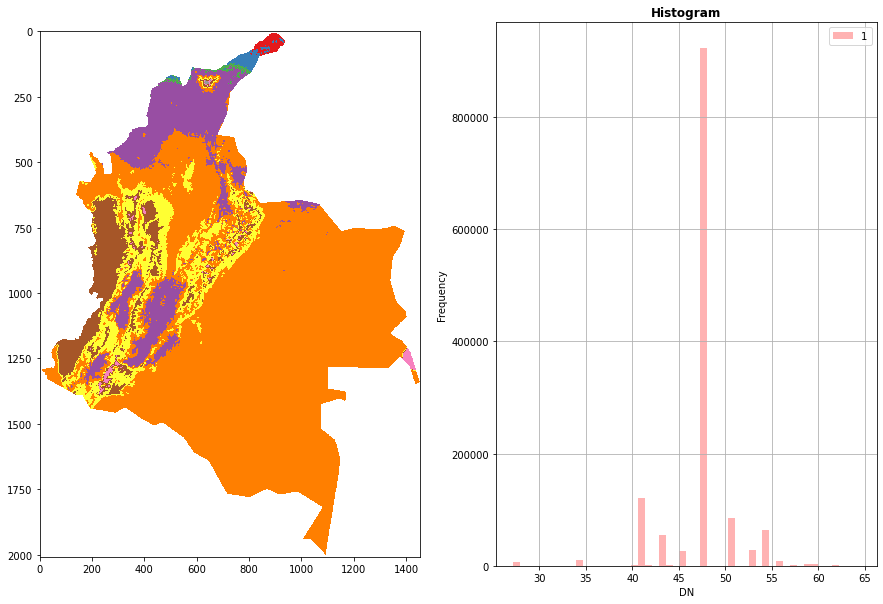

In [108]:
# Map and tiff histogram
fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(15,10))
show(lifezone_colombia, ax=axrgb, cmap='Set1')
show_hist(lifezone_colombia, bins=50, histtype='stepfilled',
          lw=0.0, stacked=False, alpha=0.3, ax=axhist)
pyplot.show()

In [163]:
lifezon = pd.DataFrame(list(set(lifezone_colombia[~np.isnan(lifezone_colombia)])), columns=['lifezone'])
lifezon.round(3)

compare = dict(zip(hold['id'], hold['simbolo']))

lifezon['simbolo'] = lifezon.lifezone.map(compare)

## **Holdrigde Colombia 2011**

| code | tipo de bosque                 | id     | elev_1 | elev_2 | elevation | amt_1 | amt_2 | temperature | tpa_1 | tpa_2 | precipitation | ecuación alométrica |
|------|--------------------------------|--------|--------|--------|-----------|-------|-------|-------------|-------|-------|---------------|---------------------|
| 45   | Bosque muy seco tropical       | bms-T  | 0      | 800    | 1         | 0     | 24    | 5           | 500   | 1000  | 9             | 1                   |
| 50   | Bosque seco tropical           | bs-T   | 0      | 800    | 1         | 0     | 24    | 5           | 1000  | 2000  | 10            | 1                   |
| 55   | Bosque húmedo tropical         | bh-T   | 0      | 800    | 1         | 0     | 24    | 5           | 2000  | 4000  | 11            | 2                   |
| 65   | Bosque muy húmedo tropical     | bmh-T  | 0      | 800    | 1         | 0     | 24    | 5           | 4000  | 8000  | 13            | 2                   |
| 75   | Bosque pluvial tropical        | bp-T   | 0      | 800    | 1         | 0     | 24    | 5           | 8000  |       | 15            | 3                   |
| 126  | Bosque seco premontano         | bs-PM  | 800    | 1800   | 2         | 18    | 24    | 7           | 500   | 1000  | 9             | 4                   |
| 160  | Bosque húmedo premontano       | bh-PM  | 800    | 1800   | 2         | 18    | 24    | 8           | 1000  | 2000  | 10            | 4                   |
| 176  | Bosque muy húmedo premontano   | bmh-PM | 800    | 1800   | 2         | 18    | 24    | 8           | 2000  | 4000  | 11            | 4                   |
| 224  | Bosque pluvial premontano      | bp-PM  | 800    | 1800   | 2         | 18    | 24    | 8           | 4000  |       | 14            | 4                   |
| 189  | Bosque seco montano bajo       | bs-MB  | 1800   | 2800   | 3         | 12    | 18    | 7           | 500   | 1000  | 9             | 5                   |
| 210  | Bosque húmedo montano bajo     | bh-MB  | 1800   | 2800   | 3         | 12    | 18    | 7           | 1000  | 2000  | 10            | 5                   |
| 231  | Bosque muy húmedo montano bajo | bmh-MB | 1800   | 2800   | 3         | 12    | 18    | 7           | 2000  | 4000  | 11            | 5                   |
| 294  | Bosque pluvial montano bajo    | bp-MB  | 1800   | 2800   | 3         | 12    | 18    | 7           | 4000  |       | 14            | 5                   |
| 216  | Bosque húmedo montano          | bh-M   | 2800   | 3700   | 4         | 6     | 12    | 6           | 500   | 1000  | 9             | 6                   |
| 240  | Bosque muy húmedo montano      | bmh-M  | 2800   | 3700   | 4         | 6     | 12    | 6           | 1000  | 2000  | 10            | 6                   |
| 288  | Bosque pluvial montano         | bp-M   | 2800   | 3700   | 4         | 6     | 12    | 6           | 2000  |       | 12            | 6                   |

In [119]:
# Not working properly

# # Getting dataframe and plotting in geopandas
# geo_df = gr.from_file('/content/lifezones/Colombia_Holdridge2005.tif').to_pandas()
# geo_df = geo_df.loc[:, ['value', 'x', 'y']]
# geo_df = geo_df.rename(columns  ={'x':'Latitude', 'y':'Longitude'})
# geo_df.to_csv('/content/lifezones/Colombia_Holdridge2005.csv', index=False)

# # creating geometry
# geometry = [Point(xy) for xy in zip(geo_df['Longitude'], geo_df['Latitude'])]
# print('Location dataframe shape: ', geo_df.shape)

# # creating geodataframe and plotting for review
# glocation = gpd.GeoDataFrame(geo_df, crs="EPSG:4326", geometry=geometry)
# glocation.plot()
# plt.show()